In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime
from scipy.integrate import odeint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import json
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
torch.set_default_device(device)
torch.set_default_dtype(torch.float64)
print("Setting default device to: ", device)
from PINN import CausalTrainingGradientBalancingODePINN, OdePINN, MLP_UModel, ThetaModel, LorenzThetaModel, LorenzOdePINN, InverseLorenzOdePINN, InverseLorenzThetaModel
from PINNModels import MLP, LambdaLayer, ConstantVariable, LearnableVariable

Setting default device to:  cuda
Setting default device to:  cuda
Setting default device to:  cuda


# Simulation Setup

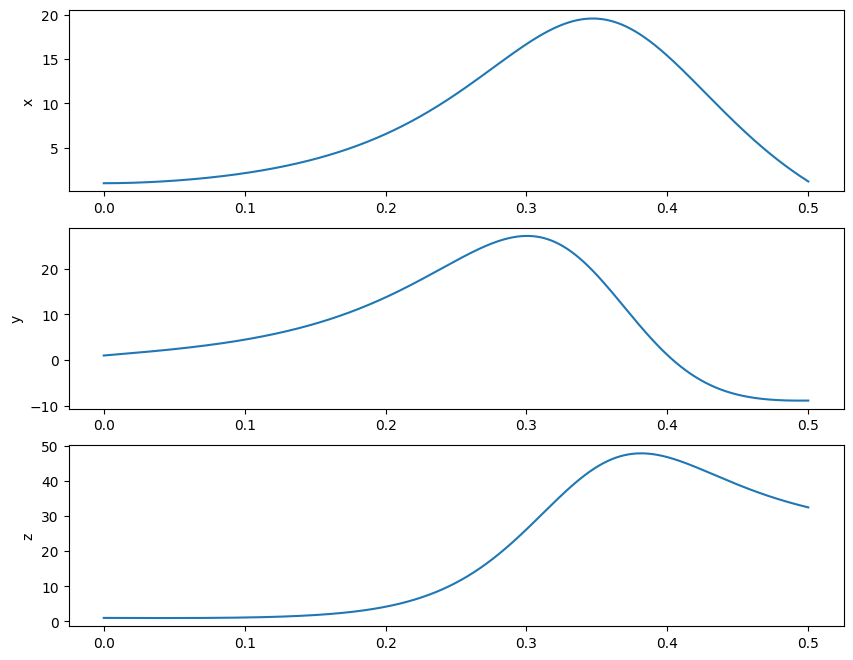

In [2]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt


# Define the system of equations for numerical solution
def system(u, t, ):
    sigma, rho, beta = 10, 28, 8/3
    x, y, z = u
    return sigma * (y - x), x * (rho -  z) - y, x * y - beta * z

t_range = np.linspace(0, 0.5, 40*1000+1)

simulate_data = odeint(func=system, y0=[1.0, 1.0, 1.0], t=t_range)

# subplot for each variable
plt.figure(figsize=(10, 8))
plt.subplot(311)
plt.plot(t_range, simulate_data[:, 0])
plt.ylabel('x')
plt.subplot(312)
plt.plot(t_range, simulate_data[:, 1])
plt.ylabel('y')
plt.subplot(313)
plt.plot(t_range, simulate_data[:, 2])
plt.ylabel('z')
plt.show()

u_data = simulate_data

# Forward

## [0, 2.0]

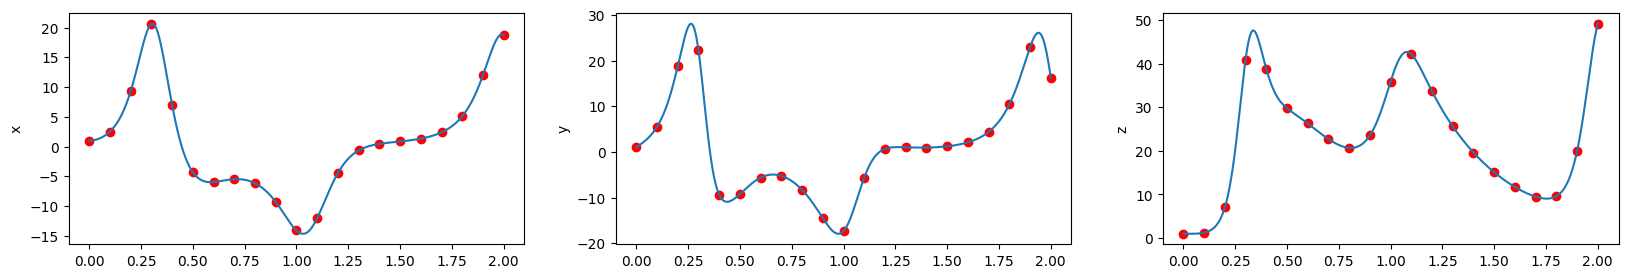

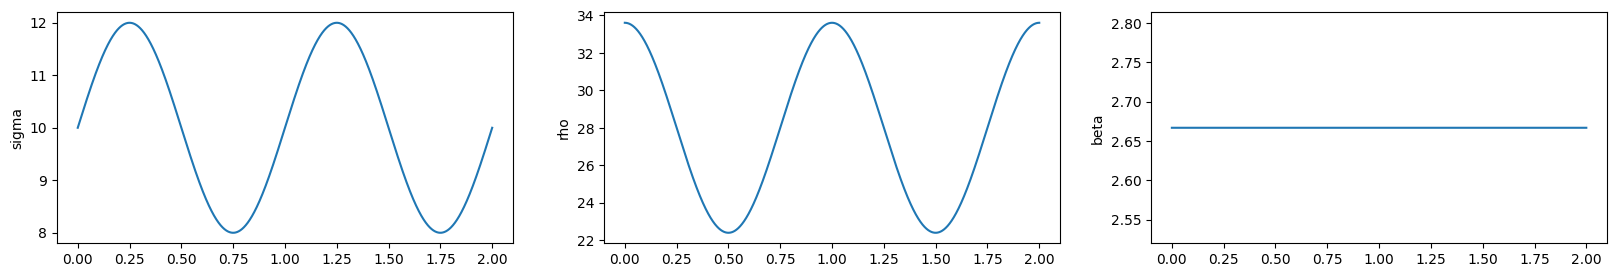

(21, 1) (21, 3) (200001,)


In [3]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt


# Define the system of equations for numerical solution
def system(u, t, ):
    # sigma, rho, beta = 10, 28, 8/3
    sigma = 10 / 5 * np.sin(t * 2 * np.pi) + 10
    rho = 28 / 5 * np.sin(t * 2 * np.pi + np.pi/2) + 28
    beta = 8/3
    x, y, z = u
    return sigma * (y - x), x * (rho -  z) - y, x * y - beta * z

t_range = np.linspace(0, 2.0, 200000+1)

simulate_data = odeint(func=system, y0=[1.0, 1.0, 1.0], t=t_range)

t_data = t_range[::10000].reshape(-1, 1)
u_data = simulate_data[::10000]
theta_data = {
    'sigma': 10 / 5 * np.sin(t_range * 2 * np.pi) + 10,
    'rho': 28 / 5 * np.sin(t_range * 2 * np.pi + np.pi/2) + 28,
    'beta': 8/3 * np.ones_like(t_range),
}

# subplot for each variable
plt.figure(figsize=(20, 3))
plt.subplot(131)
plt.plot(t_range, simulate_data[:, 0])
plt.scatter(t_data, u_data[:, 0], color='red')
plt.ylabel('x')
plt.subplot(132)
plt.plot(t_range, simulate_data[:, 1])
plt.scatter(t_data, u_data[:, 1], color='red')
plt.ylabel('y')
plt.subplot(133)
plt.plot(t_range, simulate_data[:, 2])
plt.scatter(t_data, u_data[:, 2], color='red')
plt.ylabel('z')
plt.show()


plt.show()

# plot sigma, rho, beta
plt.figure(figsize=(20, 3))
plt.subplot(131)
plt.plot(t_range, theta_data['sigma'])
plt.ylabel('sigma')
plt.subplot(132)
plt.plot(t_range, theta_data['rho'])
plt.ylabel('rho')
plt.subplot(133)
plt.plot(t_range, theta_data['beta'])
plt.ylabel('beta')

plt.show()

print(t_data.shape, u_data.shape, theta_data['sigma'].shape)


In [22]:
U_domain = [torch.min(torch.tensor(u_data), axis=0).values, torch.max(torch.tensor(u_data), axis=0).values]
U_domain_mean = (U_domain[0] + U_domain[1]) / 2
U_domain[0] = torch.minimum(U_domain_mean - 1.0, U_domain[0])
U_domain[1] = torch.maximum(U_domain_mean + 1.0, U_domain[1])
Theta_domain = {}
for key in theta_data.keys():
    Theta_domain[key] = [torch.min(torch.tensor(theta_data[key])), torch.max(torch.tensor(theta_data[key]))]
    theta_domain_mean = (Theta_domain[key][0] + Theta_domain[key][1]) / 2
    Theta_domain[key][0] = torch.minimum(theta_domain_mean - 1.0, Theta_domain[key][0])
    Theta_domain[key][1] = torch.maximum(theta_domain_mean + 1.0, Theta_domain[key][1])

In [28]:
checkpoint_list = [
    "checkpoints/PINN_Lorenz_inverse_orig/model_final.pt",
    "checkpoints/PINN_Lorenz_inverse_baseline/model_final.pt",
    "checkpoints/PINN_Lorenz_inverse_grad/model_final.pt",
    "checkpoints/PINN_Lorenz_inverse_causal/model_final.pt",
    "checkpoints/PINN_Lorenz_inverse_gradcausal/model_final.pt",
]


t_pred = torch.linspace(0, 2.0, 1000).reshape(-1, 1)
MODELS = []
list_u_pred = []
list_theta_pred = []
for ii, (model_name, checkpoint_path) in enumerate(zip(["orig", "baseline", "grad", "causal", "gradcausal"],checkpoint_list)):

    

    lorenz_pinn = InverseLorenzOdePINN(T_domain=[0.0, 2.0],
                                    U_domain=U_domain if model_name != "orig" else None,
                                    Theta_domain=Theta_domain if model_name != "orig" else None,
                                    u_data=[torch.tensor([[0.0]]), torch.tensor([[1.0, 1.0, 1.0]])],
                                    lambda_alpha=0.99, 
                                    lambda_update=None, 
                                    n_gradual_steps=0, 
                                    n_warmup_steps=0, 
                                    checkpoint_dir=None)

    lorenz_pinn.load_model(checkpoint_path)

    u_pred = lorenz_pinn.predict_u(t_pred)
    u_pred = u_pred.detach().cpu().numpy()
    list_u_pred.append(u_pred)

    theta_pred = lorenz_pinn.predict_theta(t_pred)
    theta_pred = {key: theta_pred[key].detach().cpu().numpy() for key in theta_pred.keys()}
    list_theta_pred.append(theta_pred)

    MODELS.append(lorenz_pinn)
t_pred = t_pred.detach().cpu().numpy()

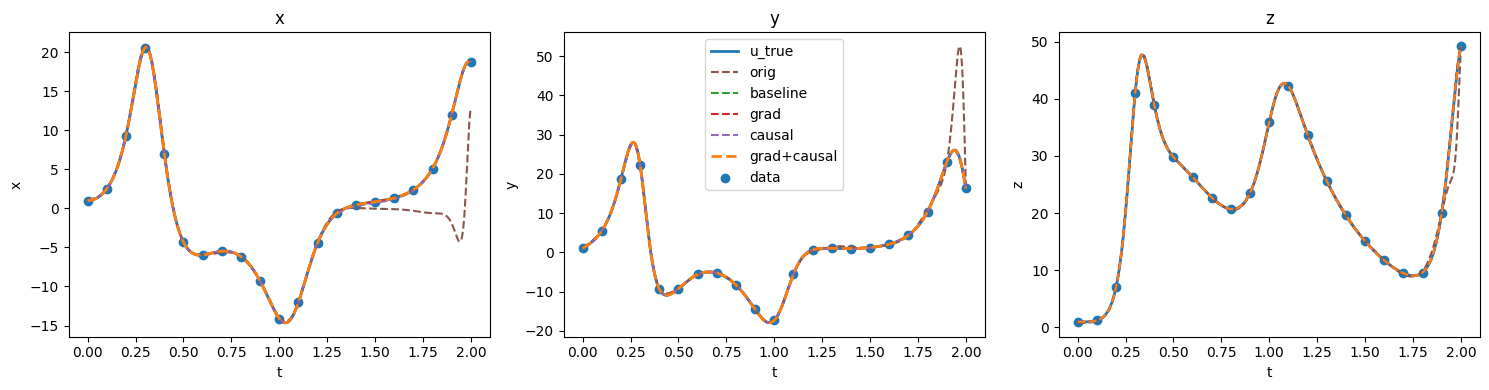

In [29]:
# Using subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(t_range, simulate_data[:, 0], "-",label='u_true', color='#1f77b4', linewidth=2)
axs[0].plot(t_pred, list_u_pred[0][:, 0], "--", label="orig", color='#8c564b')
axs[0].plot(t_pred, list_u_pred[1][:, 0], "--", label="baseline", color='#2ca02c')
axs[0].plot(t_pred, list_u_pred[2][:, 0], "--", label="grad", color='#d62728')
axs[0].plot(t_pred, list_u_pred[3][:, 0], "--", label="causal", color='#9467bd')
axs[0].plot(t_pred, list_u_pred[4][:, 0], "--", label="grad+causal", color='#ff7f0e', linewidth=2)
axs[0].scatter(t_data[:, 0], u_data[:, 0], color='#1f77b4', label='data')
axs[0].set_xlabel('t')
axs[0].set_ylabel('x')
axs[0].set_title('x')
# axs[0].legend()

# y
axs[1].plot(t_range, simulate_data[:, 1], label='u_true', color='#1f77b4', linewidth=2)
axs[1].plot(t_pred, list_u_pred[0][:, 1], "--", label="orig", color='#8c564b')
axs[1].plot(t_pred, list_u_pred[1][:, 1], "--", label="baseline", color='#2ca02c')
axs[1].plot(t_pred, list_u_pred[2][:, 1], "--", label="grad", color='#d62728')
axs[1].plot(t_pred, list_u_pred[3][:, 1], "--", label="causal", color='#9467bd')
axs[1].plot(t_pred, list_u_pred[4][:, 1], "--", label="grad+causal", color='#ff7f0e', linewidth=2)
axs[1].scatter(t_data[:, 0], u_data[:, 1], color='#1f77b4', label='data')
axs[1].set_xlabel('t')
axs[1].set_ylabel('y')
axs[1].set_title('y')
axs[1].legend()

# z
axs[2].plot(t_range, simulate_data[:, 2], label='u_true', color='#1f77b4', linewidth=2)
axs[2].plot(t_pred, list_u_pred[0][:, 2], "--", label="orig", color='#8c564b')
axs[2].plot(t_pred, list_u_pred[1][:, 2], "--", label="baseline", color='#2ca02c')
axs[2].plot(t_pred, list_u_pred[2][:, 2], "--", label="grad", color='#d62728')
axs[2].plot(t_pred, list_u_pred[3][:, 2], "--", label="causal", color='#9467bd')
axs[2].plot(t_pred, list_u_pred[4][:, 2], "--", label="grad+causal", color='#ff7f0e')
axs[2].scatter(t_data[:, 0], u_data[:, 2], color='#1f77b4', label='data')
axs[2].set_xlabel('t')
axs[2].set_ylabel('z')
axs[2].set_title('z')
# axs[2].legend()

plt.tight_layout()
plt.show()

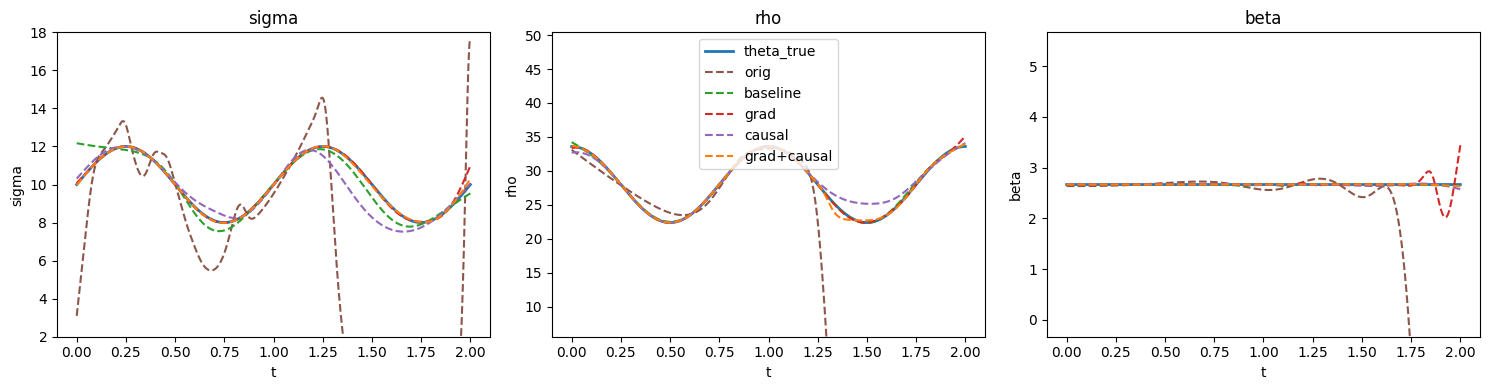

In [30]:
# similarly, plot theta_pred
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(t_range, theta_data['sigma'], label='theta_true', color='#1f77b4', linewidth=2)
axs[0].plot(t_pred, list_theta_pred[0]['sigma'], "--", label="orig", color='#8c564b')
axs[0].plot(t_pred, list_theta_pred[1]['sigma'], "--", label="baseline", color='#2ca02c')
axs[0].plot(t_pred, list_theta_pred[2]['sigma'], "--", label="grad", color='#d62728')
axs[0].plot(t_pred, list_theta_pred[3]['sigma'], "--", label="causal", color='#9467bd')
axs[0].plot(t_pred, list_theta_pred[4]['sigma'], "--", label="grad+causal", color='#ff7f0e')
axs[0].set_xlabel('t')
axs[0].set_ylabel('sigma')
axs[0].set_title('sigma')
axs[0].set_ylim(8-4*1.5, 12+4*1.5)
# axs[0].legend(loc='upper center')

# rho
axs[1].plot(t_range, theta_data['rho'], label='theta_true', color='#1f77b4', linewidth=2)
axs[1].plot(t_pred, list_theta_pred[0]['rho'], "--", label="orig", color='#8c564b')
axs[1].plot(t_pred, list_theta_pred[1]['rho'], "--", label="baseline", color='#2ca02c')
axs[1].plot(t_pred, list_theta_pred[2]['rho'], "--", label="grad", color='#d62728')
axs[1].plot(t_pred, list_theta_pred[3]['rho'], "--", label="causal", color='#9467bd')
axs[1].plot(t_pred, list_theta_pred[4]['rho'], "--", label="grad+causal", color='#ff7f0e')
axs[1].set_xlabel('t')
axs[1].set_ylabel('rho')
axs[1].set_title('rho')
axs[1].set_ylim(28-28/5-28/5*2*1.5, 28+28/5+28/5*2*1.5)
axs[1].legend(loc='upper center')

# beta
axs[2].plot(t_range, theta_data['beta'], label='theta_true', color='#1f77b4', linewidth=2)
axs[2].plot(t_pred, list_theta_pred[0]['beta'], "--", label="orig", color='#8c564b')
axs[2].plot(t_pred, list_theta_pred[1]['beta'], "--", label="baseline", color='#2ca02c')
axs[2].plot(t_pred, list_theta_pred[2]['beta'], "--", label="grad", color='#d62728')
axs[2].plot(t_pred, list_theta_pred[3]['beta'], "--", label="causal", color='#9467bd')
axs[2].plot(t_pred, list_theta_pred[4]['beta'], "--", label="grad+causal", color='#ff7f0e')
axs[2].set_xlabel('t')
axs[2].set_ylabel('beta')
axs[2].set_title('beta')
axs[2].set_ylim(8/3-3, 8/3+3)
# axs[2].legend()
plt.tight_layout()



# END